In [1]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

#from scrambler.models import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_protein_logo, plot_protein_importance_scores

from rosetta_utils import make_a3m, parse_a3m, one_hot_encode_msa, load_trrosetta_model, optimize_trrosetta_scores


Using TensorFlow backend.


In [2]:
#Load MSA-free sequence

sequence_name = "hallucinated_0959"

fig_name = sequence_name

a3m = ["MTVSKIADAIGAALQEEGFNISSFTVQAHPDNGVFRVNITLMFPKDDYEKLQQRLLKAVRRAAEEAGYNITDLDISYSEHTYNGKKWRTLSLSFYVRVPP"]
msa_one_hot = np.expand_dims(one_hot_encode_msa(make_a3m(a3m)), axis=0)[:, :1, ...]

x = msa_one_hot[:, :1, :, :20]

print(x.shape)


(1, 1, 100, 20)


In [3]:
#Initialize sequence encoder

seq_length = x.shape[2]

residues = list("ARNDCQEGHILKMFPSTWYV")
residue_map = {
    residue : residue_ix
    for residue_ix, residue in enumerate(residues)
}

encoder = OneHotEncoder(seq_length=seq_length, channel_map=residue_map)


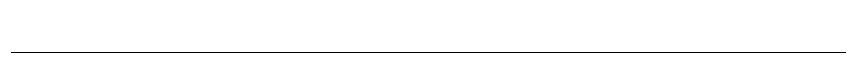

In [4]:
#Define background distribution (naturally occuring residue frequency from PDB)

x_mean = np.tile(np.array([0.07892653, 0.04979037, 0.0451488 , 0.0603382 , 0.01261332,
    0.03783883, 0.06592534, 0.07122109, 0.02324815, 0.05647807,
    0.09311339, 0.05980368, 0.02072943, 0.04145316, 0.04631926,
    0.06123779, 0.0547427 , 0.01489194, 0.03705282, 0.0691271]).reshape(1, -1), (seq_length, 1))

plot_protein_logo(residue_map, np.copy(x_mean), sequence_template='$' * seq_length, figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=seq_length)


In [5]:
#Calculate mean training set kl-divergence against background

x_clipped = np.clip(np.copy(x[:, 0, :, :]), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_clipped * np.log(x_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_div = np.mean(kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 4.166424666946717


In [6]:
#Load trRosetta predictor

model_path = 'model2019_07/model.xaa_batched.h5'

predictor = load_trrosetta_model(model_path)

predictor.trainable = False
predictor.compile(
    loss='mse',
    optimizer=keras.optimizers.SGD(lr=0.1)
)


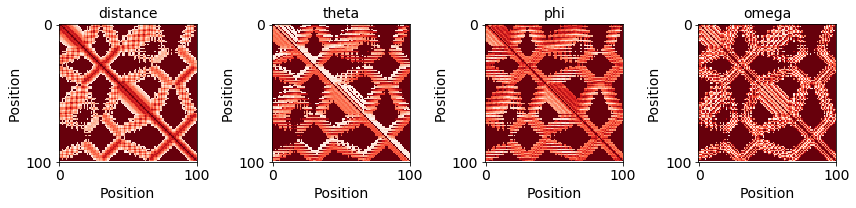

In [16]:
#Test predictor on sequence

save_figs = False

pd, pt, pp, po = predictor.predict(x=[x[:, 0, :, :], np.concatenate([x, np.zeros((1, 1, x.shape[2], 1))], axis=-1)], batch_size=1)

f, ax_list = plt.subplots(1, 4, figsize=(12, 3))

p_list = [
    [pd, 'distance', ax_list[0]],
    [pt, 'theta', ax_list[1]],
    [pp, 'phi', ax_list[2]],
    [po, 'omega', ax_list[3]]
]

for p_keras, p_name, p_ax in p_list :

    p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)

    p_ax.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

    p_ax.set_title(p_name, fontsize=14)
    p_ax.set_xlabel("Position", fontsize=14)
    p_ax.set_ylabel("Position", fontsize=14)

    plt.sca(p_ax)

    plt.xticks([0, p_keras_vals.shape[0]], [0, p_keras_vals.shape[0]], fontsize=14)
    plt.yticks([0, p_keras_vals.shape[1]], [0, p_keras_vals.shape[1]], fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + '_p_distribs.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '_p_distribs.svg')
    plt.savefig(fig_name + '_p_distribs.eps')

plt.show()


In [7]:
#Interpret the sequence usin inclusion scrambling

pwm, sample, importance_scores, train_histories = optimize_trrosetta_scores(
    predictor,
    x,
    batch_size=1,
    n_iters=500,
    input_background=x_mean,
    scrambler_mode='inclusion',
    norm_mode='instance',
    adam_accum_iters=2,
    adam_lr=0.01,
    adam_beta_1=0.5,
    adam_beta_2=0.9,
    n_samples=4,
    sample_mode='gumbel',
    entropy_mode='target',
    entropy_bits=1.,
    entropy_weight=10.
)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Finetuning batch 0...
Epoch 1/1
500/500 [==============================] - 183s 365ms/step - loss: 5.1968 - nll_loss: 4.6174 - entropy_loss: 0.5794


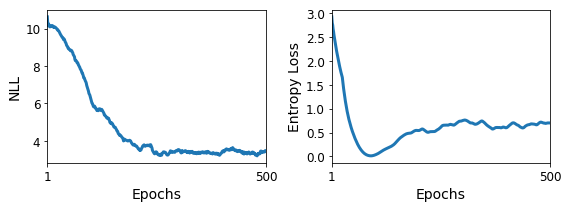

In [8]:

def _rolling_average(x, window=1) :
    x_avg = []
    
    for j in range(x.shape[0]) :
        j_min = max(j - window + 1, 0)
        x_avg.append(np.mean(x[j_min:j+1]))
    
    return np.array(x_avg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(train_histories[0]['nll'])

nll_rolling_window = 25
entropy_rolling_window = 25

for i in range(len(train_histories)) :
    ax1.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.array(train_histories[i]['nll']), window=nll_rolling_window), linewidth=3)

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

for i in range(len(train_histories)) :
    ax2.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.array(train_histories[i]['entropy']), window=entropy_rolling_window), linewidth=3)

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


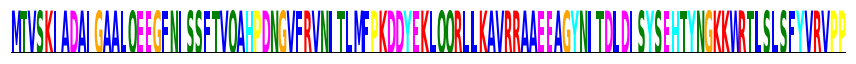

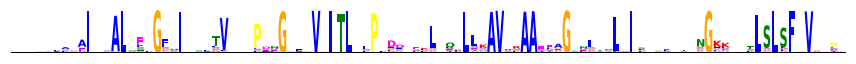

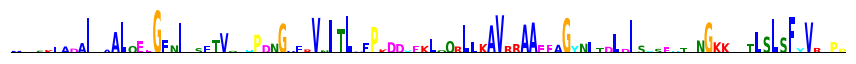

In [10]:
#Visualize the reconstructed sequence pattern

save_figs = False

plot_protein_logo(residue_map, x[0, 0, :, :], sequence_template='$' * seq_length, figsize=(12, 1), plot_start=0, plot_end=seq_length, save_figs=save_figs, fig_name=fig_name + "_orig_sequence")
plot_protein_logo(residue_map, pwm[0, 0, :, :], sequence_template='$' * seq_length, figsize=(12, 1), plot_start=0, plot_end=seq_length, save_figs=save_figs, fig_name=fig_name + "_scrambled_pwm")
plot_protein_importance_scores(importance_scores[0, 0, :, :].T, encoder.decode(x[0, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template='$' * seq_length, plot_start=0, plot_end=seq_length, save_figs=save_figs, fig_name=fig_name + "_scores")


In [20]:
#Test reconstructive ability on scrambled samples

n_samples = 512

nts = np.arange(20)

samples = np.zeros((n_samples, 1, pwm.shape[2], pwm.shape[3]))
for sample_ix in range(n_samples) :
    for j in range(pwm.shape[2]) :
        
        rand_nt = np.random.choice(nts, p=pwm[0, 0, j, :])
        samples[sample_ix, 0, j, rand_nt] = 1.

samples_msa = np.concatenate([
    samples,
    np.zeros((samples.shape[0], samples.shape[1], samples.shape[2], 1))
], axis=-1)


In [21]:
#Test predictor on scrambled sequences

pd_scrambled, pt_scrambled, pp_scrambled, po_scrambled = predictor.predict(x=[samples[:, 0, :, :], samples_msa], batch_size=4)


In [22]:
#Calculate KL-divergences to unscrambled distributions

def _get_kl_divergence_numpy(p_dist, p_theta, p_phi, p_omega, t_dist, t_theta, t_phi, t_omega) :
    
    kl_dist = np.mean(np.sum(t_dist * np.log(t_dist / p_dist), axis=-1), axis=(-2, -1))
    kl_theta = np.mean(np.sum(t_theta * np.log(t_theta / p_theta), axis=-1), axis=(-2, -1))
    kl_phi = np.mean(np.sum(t_phi * np.log(t_phi / p_phi), axis=-1), axis=(-2, -1))
    kl_omega = np.mean(np.sum(t_omega * np.log(t_omega / p_omega), axis=-1), axis=(-2, -1))
    
    return kl_dist + kl_theta + kl_phi + kl_omega

kl_divs = _get_kl_divergence_numpy(pd_scrambled, pt_scrambled, pp_scrambled, po_scrambled, pd, pt, pp, po)

print("Mean KL Div = " + str(round(np.mean(kl_divs), 3)))
print("Median KL Div = " + str(round(np.median(kl_divs), 3)))


Mean KL Div = 2.728
Median KL Div = 2.676


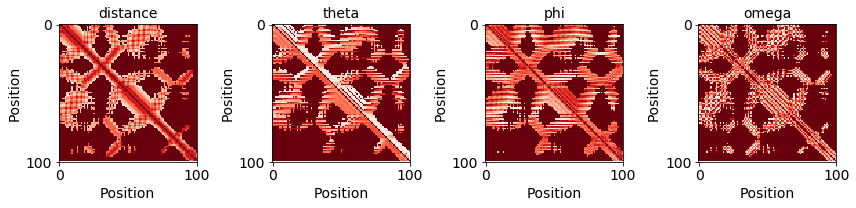

In [24]:
#Plot top x:th percentile of reconstructed contact map

save_figs = False

kl_divs_argsort = np.argsort(kl_divs)[::-1]

qt = 0.95

qt_ix = kl_divs_argsort[int(qt * kl_divs_argsort.shape[0])]

pd_scrambled_qt = pd_scrambled[qt_ix:qt_ix+1]
pt_scrambled_qt = pt_scrambled[qt_ix:qt_ix+1]
pp_scrambled_qt = pp_scrambled[qt_ix:qt_ix+1]
po_scrambled_qt = po_scrambled[qt_ix:qt_ix+1]

f, ax_list = plt.subplots(1, 4, figsize=(12, 3))

p_list = [
    [pd_scrambled_qt, 'distance', ax_list[0]],
    [pt_scrambled_qt, 'theta', ax_list[1]],
    [pp_scrambled_qt, 'phi', ax_list[2]],
    [po_scrambled_qt, 'omega', ax_list[3]]
]

for p_keras, p_name, p_ax in p_list :

    p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)

    p_ax.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

    p_ax.set_title(p_name, fontsize=14)
    p_ax.set_xlabel("Position", fontsize=14)
    p_ax.set_ylabel("Position", fontsize=14)

    plt.sca(p_ax)

    plt.xticks([0, p_keras_vals.shape[0]], [0, p_keras_vals.shape[0]], fontsize=14)
    plt.yticks([0, p_keras_vals.shape[1]], [0, p_keras_vals.shape[1]], fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + '_p_qt_' + str(qt).replace(".", "") + '_distribs.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '_p_qt_' + str(qt).replace(".", "") + '_distribs.eps')

plt.show()
